# Import Dataset, drop 0 columns

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def clean_csv_files(folder_path):
  cleaned_dataframes = {}

  # List of columns to drop
  columns_to_drop = [
      "status", "start_date", "end_date", "window_start_date", "window_end_date",
      "emails", "devs", "emails_thread_starter", "emails_thread_starter_word_count",
      "emails_thread_starter_characters", "emails_threads", "emails_threads_word_count",
      "emails_threads_characters", "emails_no_replies", "emails_no_replies_word_count",
      "emails_no_replies_characters", "emails_jira", "most_complex_unit_loc",
      "most_complex_unit_mcabe_index", "total_number_of_files", "number_of_files_main",
      "lines_of_code_main", "number_of_files_test", "lines_of_code_test",
      "test_vs_main_lines_of_code_percentage", "number_of_files_generated",
      "lines_of_code_generated", "number_of_files_build_and_deployment",
      "lines_of_code_build_and_deployment", "negligible_risk_file_size_count",
      "low_risk_file_size_count", "medium_risk_file_size_count", "high_risk_file_size_count",
      "very_high_risk_file_size_count", "negligible_risk_file_size_loc", "low_risk_file_size_loc",
      "medium_risk_file_size_loc", "high_risk_file_size_loc", "very_high_risk_file_size_loc",
      "number_of_units", "lines_of_code_in_units", "lines_of_code_outside_units",
      "unit_size_negligible_risk_loc", "unit_size_negligible_risk_count", "unit_size_low_risk_loc",
      "unit_size_low_risk_count", "unit_size_medium_risk_loc", "unit_size_medium_risk_count",
      "unit_size_high_risk_loc", "unit_size_high_risk_count", "unit_size_very_high_risk_loc",
      "unit_size_very_high_risk_count", "conditional_complexity_negligible_risk_loc",
      "conditional_complexity_negligible_risk_count", "conditional_complexity_low_risk_loc",
      "conditional_complexity_low_risk_count", "conditional_complexity_medium_risk_loc",
      "conditional_complexity_medium_risk_count", "conditional_complexity_high_risk_loc",
      "conditional_complexity_high_risk_count", "conditional_complexity_very_high_risk_loc",
      "conditional_complexity_very_high_risk_count", "conditional_complexity_high_plus_risk_count",
      "conditional_complexity_high_plus_risk_loc", "number_of_contributors",
      "duplication_number_of_duplicates", "duplication_number_of_files_with_duplicates",
      "duplication_number_of_duplicated_lines", "duplication_percentage", "unit_duplicates_count", "releases"
  ]

  for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
      file_path = os.path.join(folder_path, filename)

      # Load CSV file
      df = pd.read_csv(file_path)

      # Drop specified columns
      df = df.drop(
          columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

      key = os.path.splitext(filename)[0]
      cleaned_dataframes[key] = df

  return cleaned_dataframes

folder_path = "scraper-output"
cleaned_data = clean_csv_files(folder_path)


# Compute PCA to rank relevance of features

In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def perform_pca_on_each(cleaned_data):
  feature_importance_list = []

  for key, df in cleaned_data.items():
    # Exclude 'project', 'measurement_month', and 'programming_lang' columns
    features = df.drop(
        columns=['project', 'measurement_month', 'programming_lang'], errors='ignore')

    # Handle missing values - fill or drop NaNs
    features = features.fillna(0)

    # Drop columns with zero variance
    features = features.loc[:, features.var() > 0]

    # Check if there are any numeric features left
    numeric_features = features.select_dtypes(include=[np.number])
    if numeric_features.empty:
      print(
          f"Warning: No numeric features left for PCA in {key}. Skipping PCA.")
      continue

    # Standardize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(numeric_features)

    # Perform PCA
    pca = PCA()
    pca.fit(scaled_features)

    # Collect feature importance
    feature_importance = dict(
        zip(numeric_features.columns, pca.explained_variance_ratio_))
    feature_importance_list.append(feature_importance)

  # Compute average importance across all DataFrames
  avg_feature_importance = {}
  for feature_dict in feature_importance_list:
    for feature, importance in feature_dict.items():
      if feature not in avg_feature_importance:
        avg_feature_importance[feature] = []
      avg_feature_importance[feature].append(importance)

  # Compute final average
  avg_feature_importance = {feature: sum(
      values) / len(values) for feature, values in avg_feature_importance.items()}

  # Rank features by average importance
  ranked_features = sorted(avg_feature_importance.items(),
                           key=lambda x: x[1], reverse=True)

  # Display ranked features
  print("Final Ranked Features by Average Importance:")
  for feature, importance in ranked_features:
    print(f"{feature}: {importance:.4f}")


# Perform PCA on each DataFrame and compute overall importance
perform_pca_on_each(cleaned_data)

Final Ranked Features by Average Importance:
commits: 0.3743
authors: 0.1941
committers: 0.1070
minor_contributors: 0.0689
major_contributors: 0.0564
directories: 0.0438
top_level_dirs: 0.0367
active_days: 0.0298
files_modified: 0.0242
files_added: 0.0195
files_deleted: 0.0156
files_renamed: 0.0124
added_lines: 0.0094
deleted_lines: 0.0072
new_contributors: 0.0054
avg_files_modified_commit: 0.0040
code: 0.0028
blanks: 0.0020
files: 0.0014
comments: 0.0009
lines: 0.0005
stars: 0.0003
forks: 0.0002
open_prs: 0.0002
closed_prs: 0.0001
merged_prs: 0.0000
stale_prs: 0.0000
deploys: 0.0000


In [3]:
status_data = pd.read_csv("project-status.csv")
status_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   project  154 non-null    object
 1   status   154 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


# Time series analysis on most important features based on Programming Languages

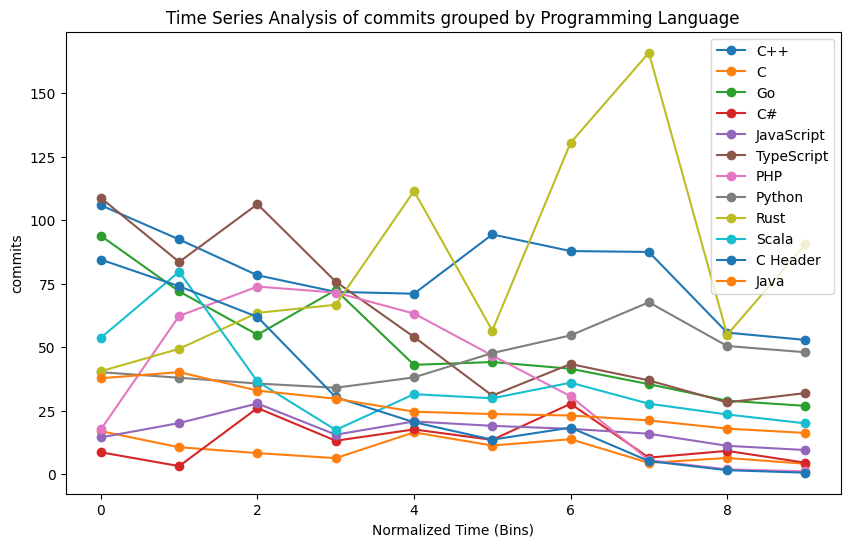

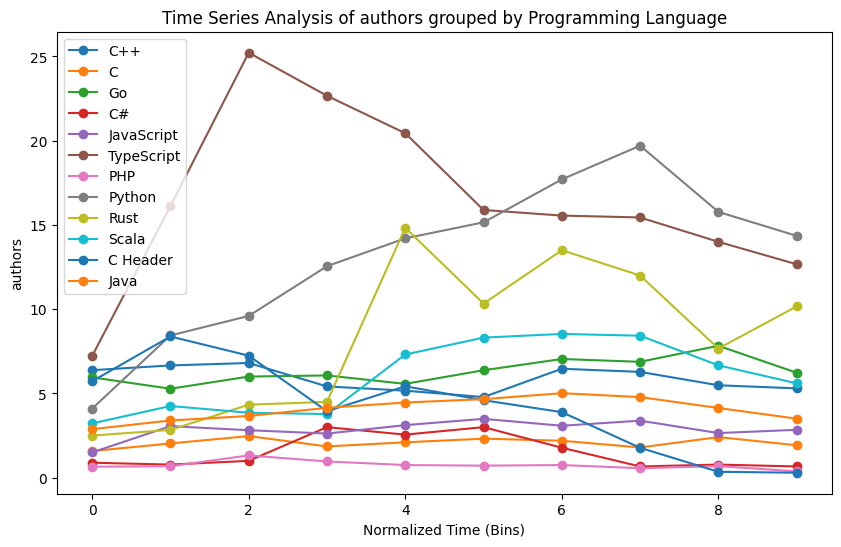

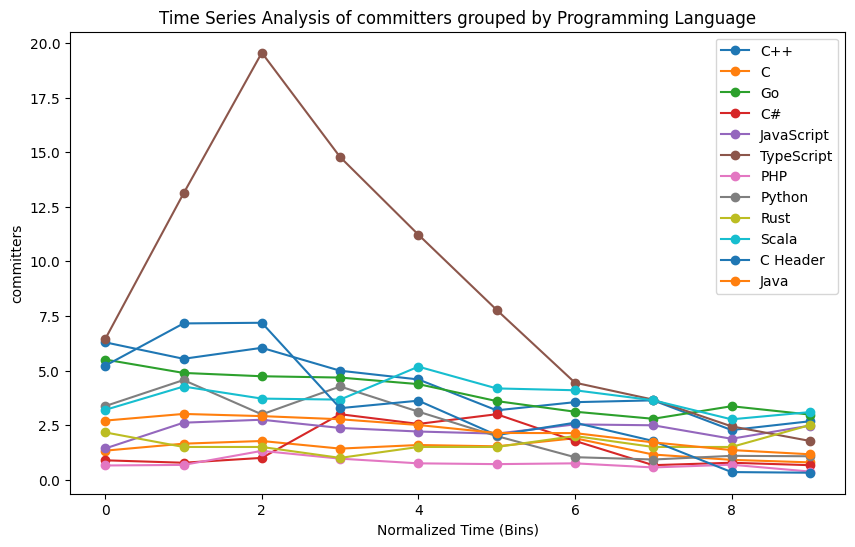

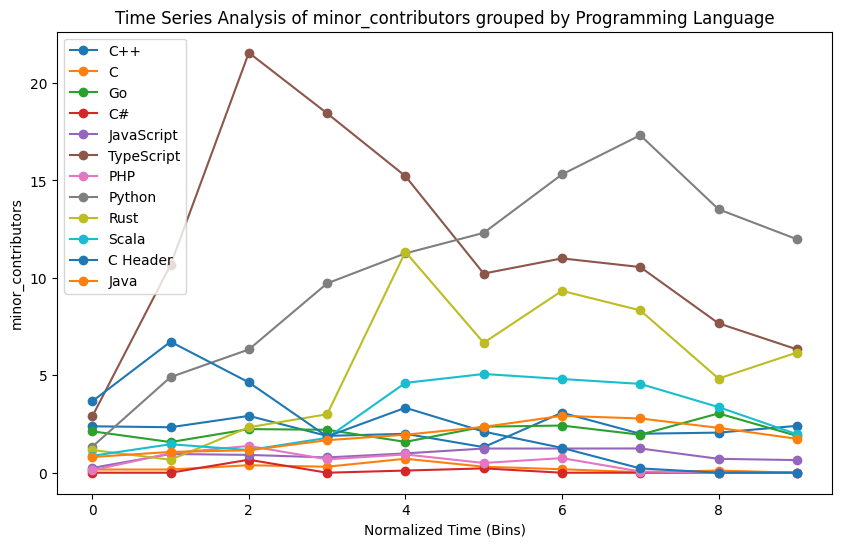

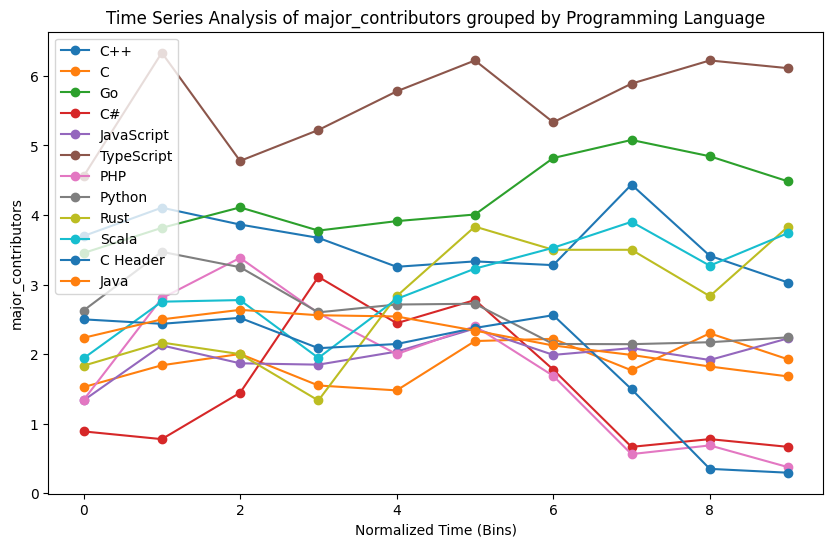

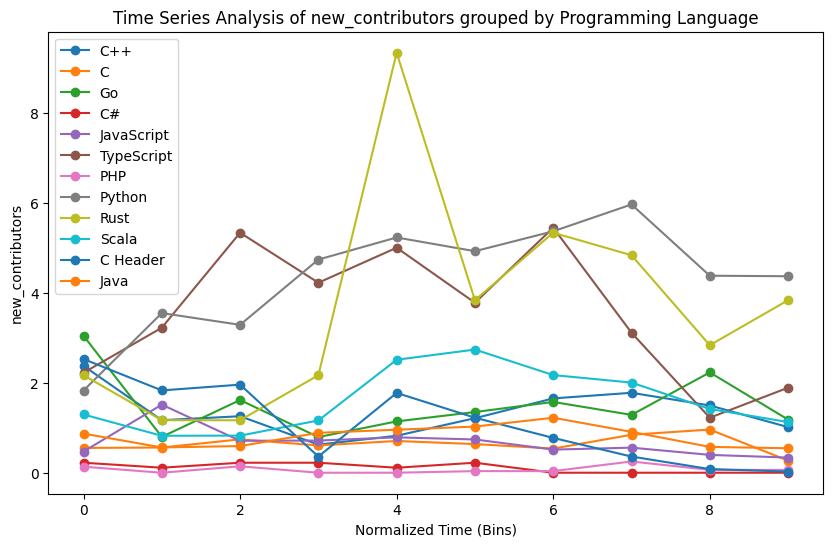

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter out projects with fewer than 10 data points
cleaned_data = {project: df for project, df in cleaned_data.items() if len(df) >= 10}

# Function to merge programming language information into each dataframe by computing the mode
def merge_programming_lang(cleaned_data):
    for project, df in cleaned_data.items():
        if 'programming_lang' in df.columns:
            mode_val = df['programming_lang'].mode()
            if not mode_val.empty:
                # Set the mode value as the programming language for the entire dataframe
                df['programming_lang'] = mode_val[0]
            else:
                df['programming_lang'] = 'Unknown'
        else:
            df['programming_lang'] = 'Unknown'
    return cleaned_data

# Function to extract 1/10th segments and compute averages
def extract_average_feature(df, feature, num_bins=10):
    df = df.sort_values(by='measurement_month')  # Ensure time is sorted
    bin_size = max(1, len(df) // num_bins)         # Determine bin size
    averages = [df[feature].iloc[i * bin_size: (i + 1) * bin_size].mean() for i in range(num_bins)]
    return averages

# Function to plot feature trends grouped by programming language
def plot_feature(cleaned_data, feature, num_bins=10):
    # Merge programming language information into each project's dataframe
    cleaned_data = merge_programming_lang(cleaned_data)
    
    # Get the unique programming languages across all projects
    languages = {df['programming_lang'].iloc[0] for project, df in cleaned_data.items()}
    
    # Prepare a dictionary to hold binned values for each programming language
    grouped_data = {lang: [[] for _ in range(num_bins)] for lang in languages}
    
    # Process each project and collect the average values per bin by programming language
    for project, df in cleaned_data.items():
        if feature in df.columns:
            lang = df['programming_lang'].iloc[0]  # Each project’s programming language (mode)
            averages = extract_average_feature(df, feature, num_bins)
            for i, avg in enumerate(averages):
                grouped_data[lang][i].append(avg)
    
    # Plot the overall average per bin for each programming language
    plt.figure(figsize=(10, 6))
    for lang, bins in grouped_data.items():
        avg_series = [np.mean(bin_values) if bin_values else 0 for bin_values in bins]
        plt.plot(range(num_bins), avg_series, marker='o', label=lang)
    
    plt.xlabel('Normalized Time (Bins)')
    plt.ylabel(feature)
    plt.title(f'Time Series Analysis of {feature} grouped by Programming Language')
    plt.legend()
    plt.show()

# Function to plot all features
def plot_all_features(cleaned_data, features, num_bins=10):
    for feature in features:
        plot_feature(cleaned_data, feature, num_bins)

# Example usage:
plot_all_features(cleaned_data, [
    'commits', 'authors', 'committers', 'minor_contributors', 'major_contributors', 'new_contributors'
])


# Time series analysis on most important features based on Project Status and Programming Languages

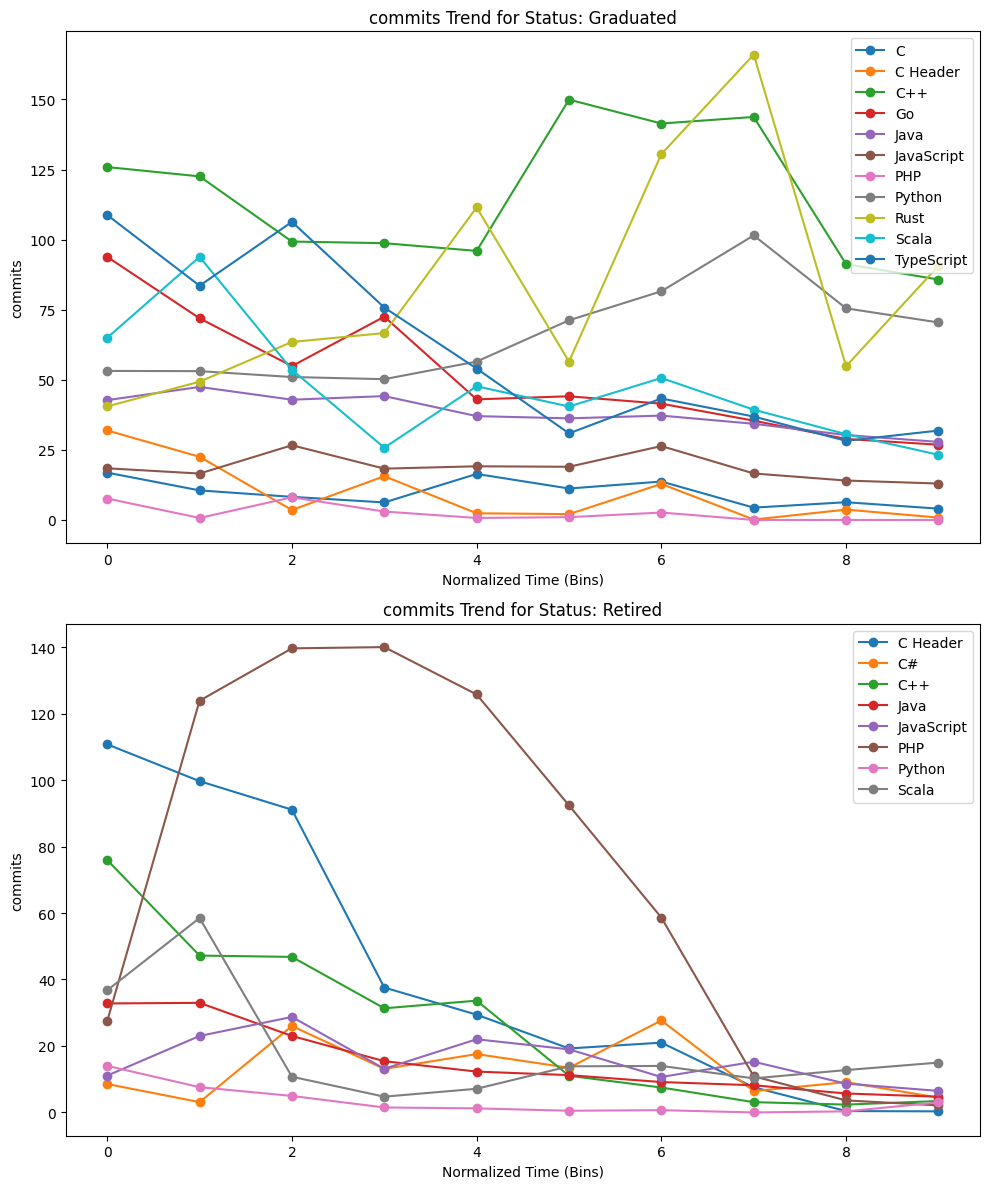

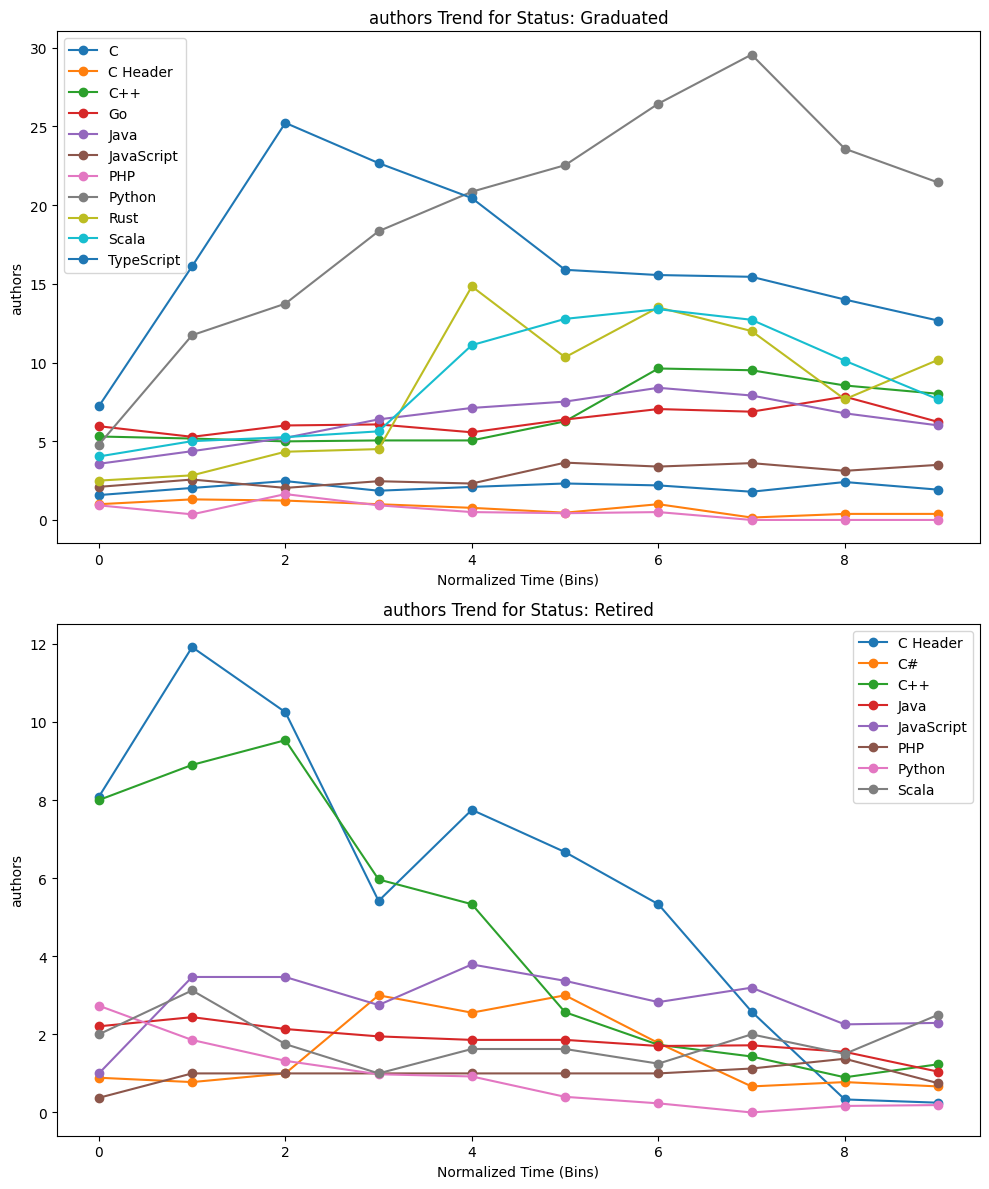

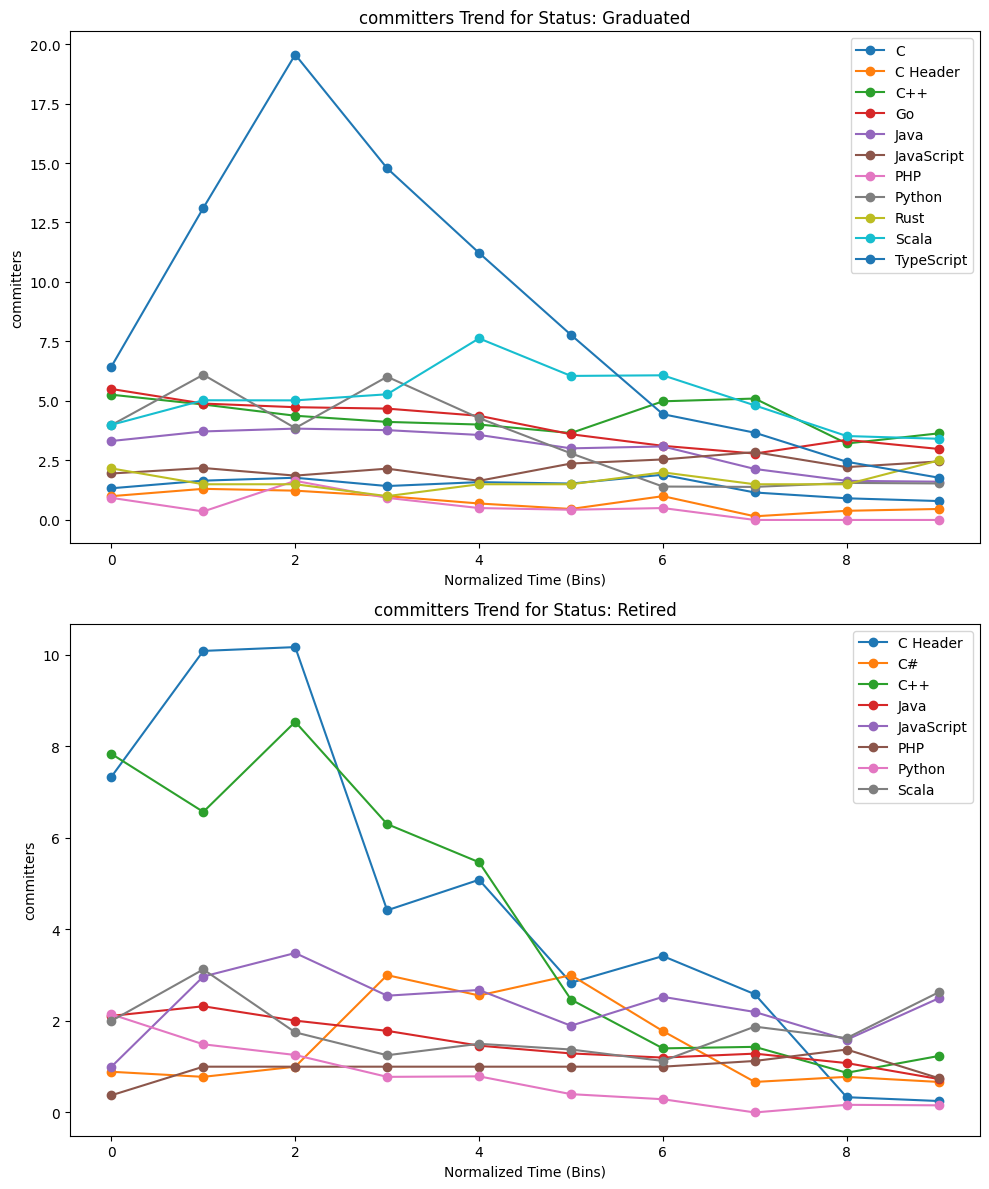

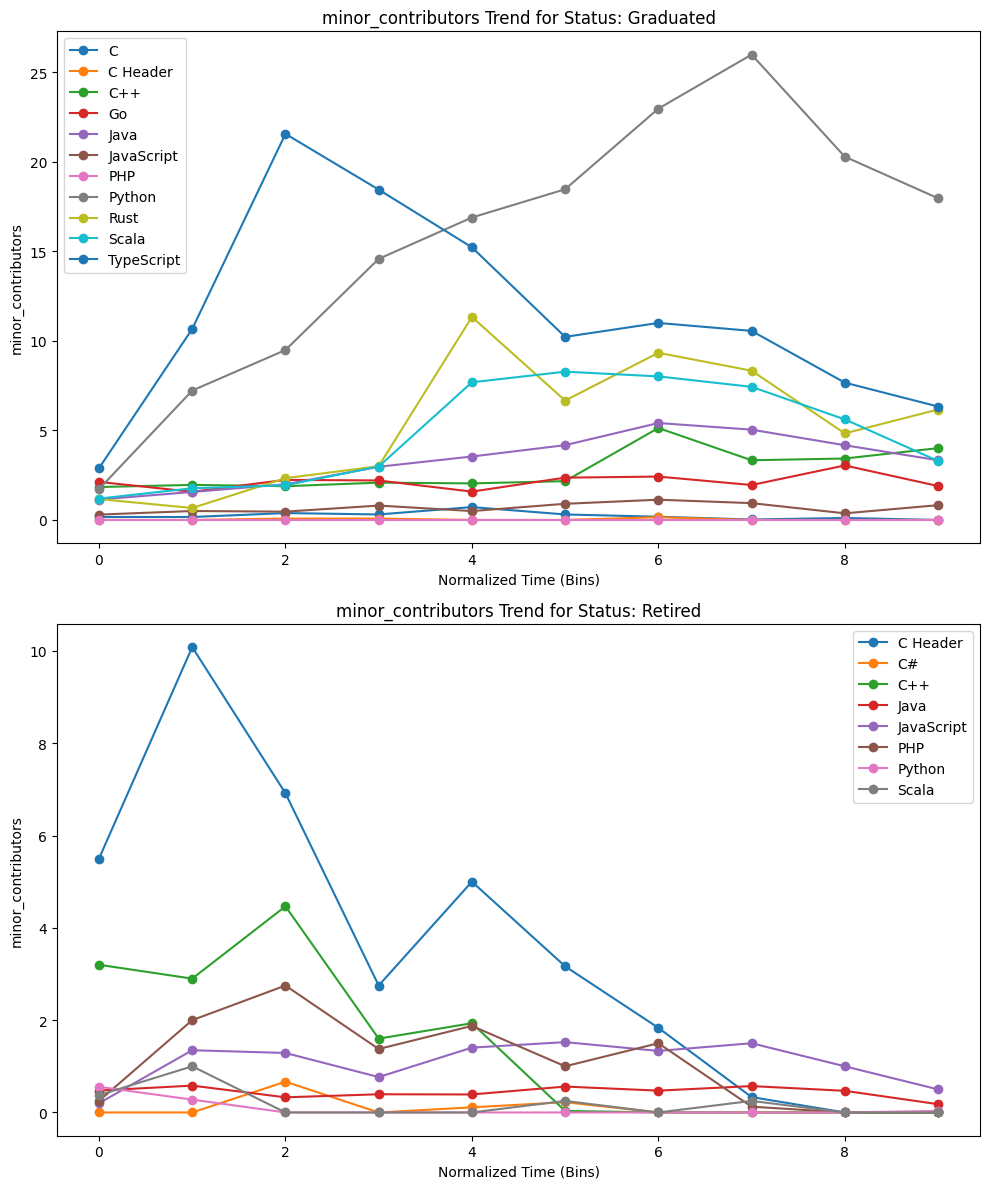

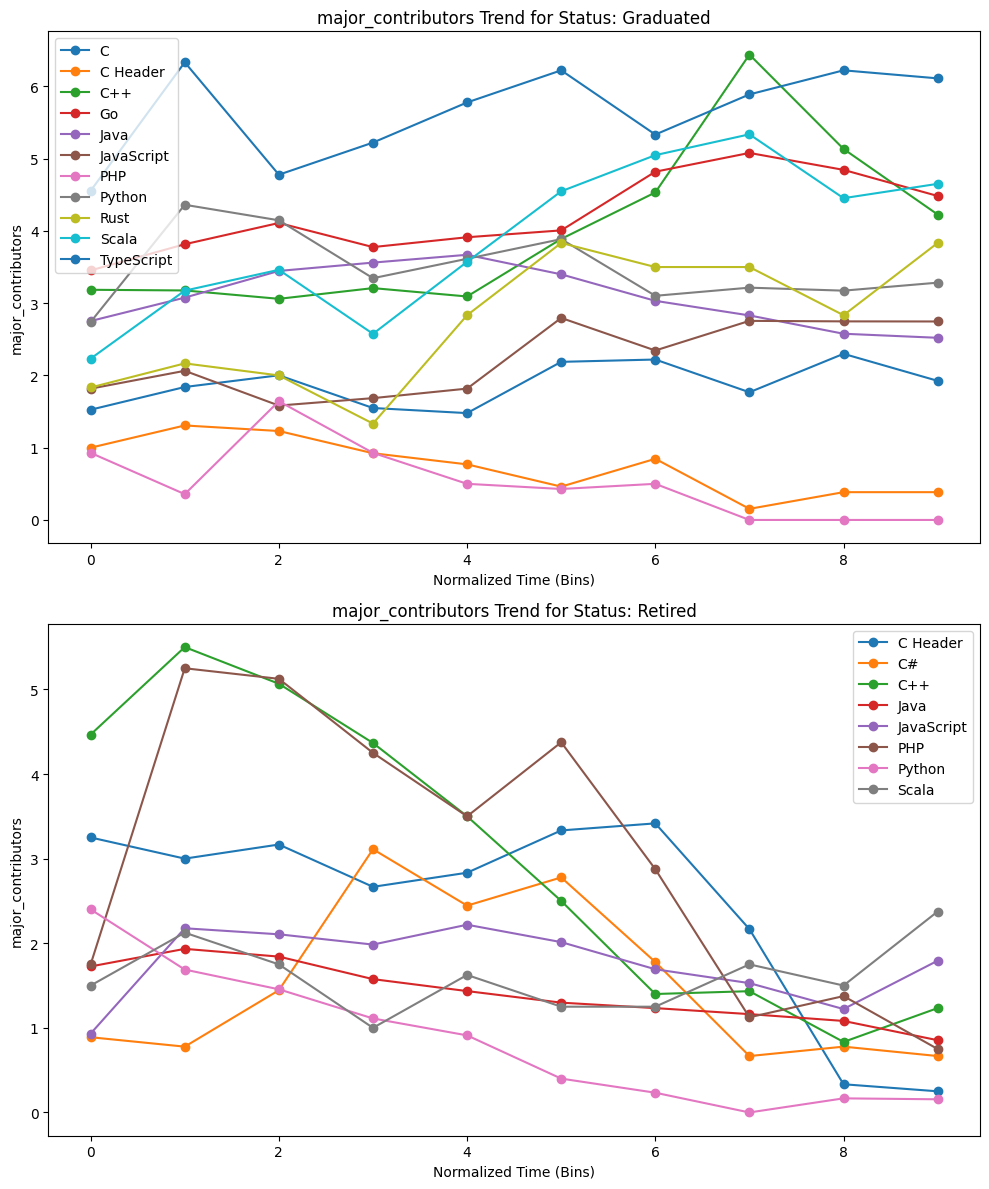

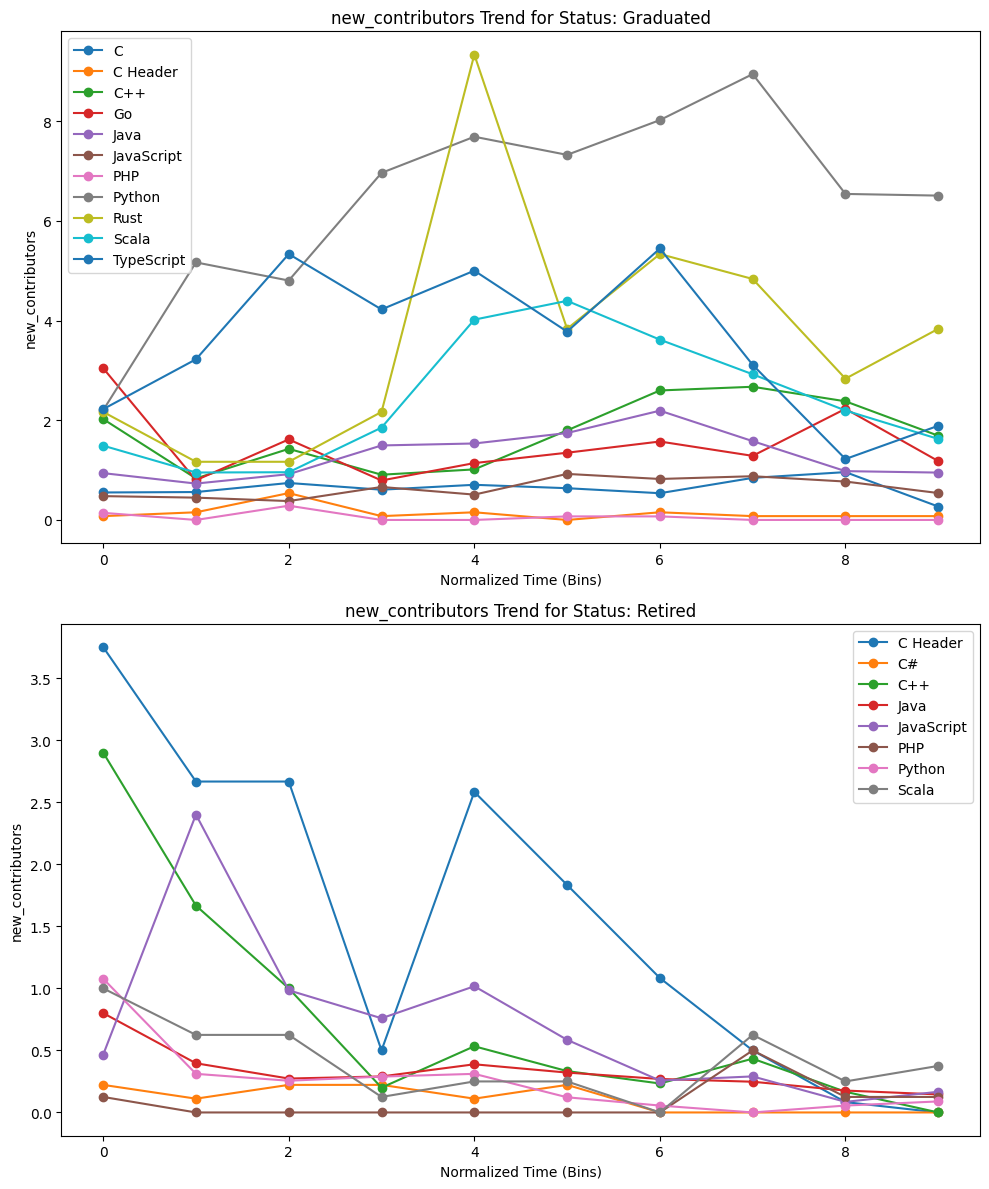

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter out projects with fewer than 10 data points
cleaned_data = {project: df for project, df in cleaned_data.items() if len(df) >= 10}

# Filter status_data to only include projects present in cleaned_data
status_data_filtered = status_data[status_data['project'].isin(cleaned_data.keys())]

# Merge project status into each dataframe
def merge_status(cleaned_data, status_data):
    status_dict = status_data.set_index('project')['status'].to_dict()
    for project, df in cleaned_data.items():
        df['status'] = status_dict.get(project, 'Unknown')
    return cleaned_data

# Merge programming language into each dataframe by computing the mode
def merge_language(cleaned_data):
    for project, df in cleaned_data.items():
        if 'programming_lang' in df.columns:
            mode_val = df['programming_lang'].mode()
            if not mode_val.empty:
                df['programming_lang'] = mode_val[0]
            else:
                df['programming_lang'] = 'Unknown'
        else:
            df['programming_lang'] = 'Unknown'
    return cleaned_data

# Function to extract 1/10th segments and compute averages for a given feature
def extract_average_feature(df, feature, num_bins=10):
    df = df.sort_values(by='measurement_month')  # Ensure time is sorted
    bin_size = max(1, len(df) // num_bins)         # Determine bin size
    averages = [df[feature].iloc[i * bin_size: (i + 1) * bin_size].mean() for i in range(num_bins)]
    return averages

# Function to plot feature trends grouped by status and further categorized by programming language
def plot_feature(cleaned_data, status_data, feature, num_bins=10):
    # Merge status and programming language info into each dataframe
    cleaned_data = merge_status(cleaned_data, status_data)
    cleaned_data = merge_language(cleaned_data)
    
    # Get unique statuses from the cleaned data
    statuses = sorted({df['status'].iloc[0] for df in cleaned_data.values()})
    
    # Create a figure with a separate subplot for each status
    num_statuses = len(statuses)
    plt.figure(figsize=(10, 6 * num_statuses))
    
    for i, status in enumerate(statuses, 1):
        # Filter projects by current status
        projects_for_status = {project: df for project, df in cleaned_data.items() 
                               if df['status'].iloc[0] == status}
        
        # Get unique programming languages in this status group
        languages = sorted({df['programming_lang'].iloc[0] for df in projects_for_status.values()})
        
        # Create nested dictionary: for each language, store a list (one per bin) of average values
        grouped_data = {lang: [[] for _ in range(num_bins)] for lang in languages}
        
        # Process each project in the current status group
        for project, df in projects_for_status.items():
            if feature in df.columns:
                lang = df['programming_lang'].iloc[0]
                averages = extract_average_feature(df, feature, num_bins)
                for j, avg in enumerate(averages):
                    grouped_data[lang][j].append(avg)
        
        # Plot overall average per bin for each programming language within the current status group
        ax = plt.subplot(num_statuses, 1, i)
        for lang, bins in grouped_data.items():
            avg_series = [np.mean(bin_vals) if bin_vals else 0 for bin_vals in bins]
            plt.plot(range(num_bins), avg_series, marker='o', label=lang)
        plt.xlabel('Normalized Time (Bins)')
        plt.ylabel(feature)
        plt.title(f'{feature} Trend for Status: {status}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Function to plot all features
def plot_all_features(cleaned_data, status_data, features, num_bins=10):
    for feature in features:
        plot_feature(cleaned_data, status_data, feature, num_bins)

# Example usage:
plot_all_features(cleaned_data, status_data, [
    'commits', 'authors', 'committers', 'minor_contributors', 'major_contributors','new_contributors'
])
